<a href="https://colab.research.google.com/github/stfromnjust/nlp-task/blob/main/Seq2SeqForTranslation_useSpaCyJieba_20210606noon2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 下载数据 必要配置

In [1]:
!apt install lshw -y
!lshw -C display

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libpci3 pciutils usbutils
The following NEW packages will be installed:
  libpci3 lshw pciutils usbutils
0 upgraded, 4 newly installed, 0 to remove and 39 not upgraded.
Need to get 723 kB of archives.
After this operation, 2,883 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libpci3 amd64 1:3.5.2-1ubuntu1.1 [24.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 lshw amd64 02.18-0.1ubuntu6.18.04.2 [234 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 pciutils amd64 1:3.5.2-1ubuntu1.1 [257 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 usbutils amd64 1:007-4build1 [208 kB]
Fetched 723 kB in 1s (612 kB/s)
Selecting previously unselected package libpci3:amd64.
(Reading database ... 160772 files and directories currently installed

In [107]:
!/opt/bin/nvidia-smi

Sun Jun  6 09:08:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    35W / 250W |   2907MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!wget https://github.com/stfromnjust/nlp-task/raw/main/cmn-eng.zip
!unzip -d ./cmn-eng cmn-eng.zip

--2021-06-06 07:27:59--  https://github.com/stfromnjust/nlp-task/raw/main/cmn-eng.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/stfromnjust/nlp-task/main/cmn-eng.zip [following]
--2021-06-06 07:27:59--  https://raw.githubusercontent.com/stfromnjust/nlp-task/main/cmn-eng.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1049235 (1.0M) [application/zip]
Saving to: ‘cmn-eng.zip’

cmn-eng.zip         100%[===================>]   1.00M  --.-KB/s    in 0.04s   

2021-06-06 07:27:59 (22.6 MB/s) - ‘cmn-eng.zip’ saved [1049235/1049235]

Archive:  cmn-eng.zip
   creating: ./cmn-eng/cmn-eng/
  

In [3]:
seed = 2030

In [4]:
!pip install opencc
!pip install torchviz

     |████████████████████████████████| 768kB 8.7MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.2-cp37-none-any.whl size=4152 sha256=b71582143d8e004e35cb36753ec649924e50ff75c9c3865e3432dff3f130c0c6
  Stored in directory: /root/.cache/pip/wheels/01/26/58/026ffd533dbe8b3972eb423da9c7949beca68d1c98ed9e8624
Successfully built torchviz


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtext.legacy.data import *


import time
import math
import random
import jieba
import spacy
import opencc

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# 读取数据

In [7]:
# 每一行数据如下
# 'Hi.\t嗨。\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #891077 (Martha)'
with open('./cmn-eng/cmn-eng/cmn.txt', 'r', encoding='utf-8') as f:
    data = f.read()
data = data.strip()
data = data.split('\n')
print('样本数:\n', len(data))
print('\n样本示例:')
data[0]

样本数:
 24818

样本示例:


'Hi.\t嗨。\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #891077 (Martha)'

In [8]:
# 分割英文数据和中文数据
# 繁体中文转简体中文
cc = opencc.OpenCC('t2s')

en_data = [line.split('\t')[0].lower() for line in data]
ch_data = [cc.convert(line.split('\t')[1]) for line in data]

print('英文数据:\n', en_data[:10])
print('\n中文数据:\n', ch_data[:10])

英文数据:
 ['hi.', 'hi.', 'run.', 'wait!', 'wait!', 'hello!', 'i try.', 'i won!', 'oh no!', 'cheers!']

中文数据:
 ['嗨。', '你好。', '你用跑的。', '等等！', '等一下！', '你好。', '让我来。', '我赢了。', '不会吧。', '干杯!']


# 分词

In [9]:
# 中文使用jieba分词
ch_token_list = []
for line in ch_data:
  ch_token_list.append(list(jieba.cut(line)) + ['<eos>'])

# 英文使用spacy分词
nlp = spacy.load('en')
en_token_list = []
for line in en_data:
  doc = nlp(line)
  en_new = []
  for token in doc:
    en_new.append(token.text)
  en_token_list.append(en_new + ['<eos>'])

# 测试
print('英文数据:\n', en_token_list[:3])
print('\n中文数据:\n', ch_token_list[:3])

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.997 seconds.
Prefix dict has been built successfully.


英文数据:
 [['hi', '.', '<eos>'], ['hi', '.', '<eos>'], ['run', '.', '<eos>']]

中文数据:
 [['嗨', '。', '<eos>'], ['你好', '。', '<eos>'], ['你', '用', '跑', '的', '。', '<eos>']]


# 建立词典

In [10]:
ch_TEXT = Field()
ch_TEXT.build_vocab(ch_token_list[:21622], specials=['<pad>', '<unk>', '<bos>', '<eos>'])
en_TEXT = Field()
en_TEXT.build_vocab(en_token_list[:21622], specials=['<pad>', '<unk>', '<bos>', '<eos>'])

print('中文词典: ')
print(len(ch_TEXT.vocab))
print(ch_TEXT)
print(ch_TEXT.vocab.itos[:20])
print(ch_TEXT.vocab.stoi['<unk>'])
print('\n英文词典: ')
print(len(en_TEXT.vocab))
print(en_TEXT)
print(en_TEXT.vocab.itos[:20])
print(en_TEXT.vocab.stoi['<unk>'])

中文词典: 
10742
['<unk>', '<pad>', '<bos>', '<eos>', '。', '我', '的', '了', '你', '他', '？', '在', '汤姆', '是', '她', '吗', '我们', '，', '不', '很']
0

英文词典: 
6288
['<unk>', '<pad>', '<bos>', '<eos>', '.', 'i', 'the', 'to', 'you', 'a', '?', 'is', 'he', "n't", 'tom', 'do', 'it', 'in', "'s", 'of']
0


In [11]:
# 利用字典，映射数据 
en_num_data = [[en_TEXT.vocab.stoi[token] for token in line ] for line in en_token_list]
ch_num_data = [[ch_TEXT.vocab.stoi[token] for token in line] for line in ch_token_list]

print('char:', en_data[1])
print('index:', en_num_data[1])

char: hi.
index: [1878, 4, 3]


# 表示为Dataset

In [12]:
class TranslationDataset(Dataset):
    def __init__(self, src_data, trg_data):
        self.src_data = src_data
        self.trg_data = trg_data

        assert len(src_data) == len(trg_data), \
            "numbers of src_data  and trg_data must be equal!"

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        src_sample =self.src_data[idx]
        src_len = len(self.src_data[idx])
        trg_sample = self.trg_data[idx]
        trg_len = len(self.trg_data[idx])
        return {"src": src_sample, "src_len": src_len, "trg": trg_sample, "trg_len": trg_len}

In [13]:
def padding_batch(batch):
    """
    input: -> list of dict
        [{'src': [1, 2, 3], 'trg': [1, 2, 3]}, {'src': [1, 2, 2, 3], 'trg': [1, 2, 2, 3]}]
    output: -> dict of tensor 
        {
            "src": [[1, 2, 3, 0], [1, 2, 2, 3]].T
            "trg": [[1, 2, 3, 0], [1, 2, 2, 3]].T
        }
    """
    src_lens = [d["src_len"] for d in batch]
    trg_lens = [d["trg_len"] for d in batch]
    
    src_max = max([d["src_len"] for d in batch])
    trg_max = max([d["trg_len"] for d in batch])
    for d in batch:
        d["src"].extend([en_TEXT.vocab.stoi["<pad>"]] * (src_max-d["src_len"]))
        d["trg"].extend([ch_TEXT.vocab.stoi["<pad>"]] * (trg_max-d["trg_len"]))
    srcs = torch.tensor([pair["src"] for pair in batch], dtype=torch.long, device=device)
    trgs = torch.tensor([pair["trg"] for pair in batch], dtype=torch.long, device=device)
    
    batch = {"src":srcs.T, "src_len":src_lens, "trg":trgs.T, "trg_len":trg_lens}
    return batch

# Attention机制

In [58]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout=0.5, bidirectional=True):
        super(Encoder, self).__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.gru = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout, bidirectional=bidirectional)
        
    def forward(self, input_seqs, input_lengths, hidden):
        # input_seqs = [seq_len, batch]
        embedded = self.embedding(input_seqs)
        # embedded = [seq_len, batch, embed_dim]
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths, enforce_sorted=False)
        
        outputs, hidden = self.gru(packed, hidden)        
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        # outputs = [seq_len, batch, hid_dim * n directions]
        # output_lengths = [batch]
        return outputs, hidden

In [59]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)  # [seq_len, batch]

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)  # [seq_len, batch, hid_dim]
        return torch.sum(hidden * energy, dim=2)  # [seq_len, batch]

    def concat_score(self, hidden, encoder_output):
        # hidden.expand(encoder_output.size(0), -1, -1) -> [seq_len, batch, N]
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        # energy = [sql_len, batch, hidden_size]
        return torch.sum(self.v * energy, dim=2)  # [seq_len, batch]

    def forward(self, hidden, encoder_outputs):
        # hidden = [1, batch,  n_directions * hid_dim]
        # encoder_outputs = [seq_len, batch, hid dim * n directions]
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        attn_energies = attn_energies.t()  # [batch, seq_len]
 
        return F.softmax(attn_energies, dim=1).unsqueeze(1)  # softmax归一化# [batch, 1, seq_len]

In [60]:
class AttnDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers=1, dropout=0.5, bidirectional=True, attn_method="general"):
        super(AttnDecoder, self).__init__()

        self.output_dim = output_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout, bidirectional=bidirectional)
        
        if bidirectional:
            self.concat = nn.Linear(hid_dim * 2 * 2, hid_dim*2)
            self.out = nn.Linear(hid_dim*2, output_dim)
            self.attn = Attn(attn_method, hid_dim*2)
        else:
            self.concat = nn.Linear(hid_dim * 2, hid_dim)
            self.out = nn.Linear(hid_dim, output_dim)
            self.attn = Attn(attn_method, hid_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, token_inputs, last_hidden, encoder_outputs):
        batch_size = token_inputs.size(0)
        embedded = self.embedding(token_inputs)
        embedded = self.embedding_dropout(embedded)
        embedded = embedded.view(1, batch_size, -1) # [1, B, hid_dim]

        gru_output, hidden = self.gru(embedded, last_hidden)
        # gru_output = [1, batch,  n_directions * hid_dim]
        # hidden = [n_layers * n_directions, batch, hid_dim]

        # encoder_outputs = [sql_len, batch, hid dim * n directions]
        attn_weights = self.attn(gru_output, encoder_outputs)
        # attn_weights = [batch, 1, sql_len]
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # [batch, 1, hid_dim * n directions]

        # LuongAttention
        gru_output = gru_output.squeeze(0) # [batch, n_directions * hid_dim]
        context = context.squeeze(1)       # [batch, n_directions * hid_dim]
        concat_input = torch.cat((gru_output, context), 1)  # [batch, n_directions * hid_dim * 2]
        concat_output = torch.tanh(self.concat(concat_input))  # [batch, n_directions*hid_dim]

        output = self.out(concat_output)  # [batch, output_dim]
        output = self.softmax(output)

        return output, hidden, attn_weights

In [61]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 device, 
                 predict=False, 
                 basic_dict=None,
                 max_len=50
                 ):
        super(Seq2Seq, self).__init__()
        
        self.device = device

        self.encoder = encoder
        self.decoder = decoder

        self.predict = predict  # 训练阶段还是预测阶段
        self.basic_dict = basic_dict  # decoder的字典，存放特殊token对应的id
        self.max_len = max_len  # 翻译时最大输出长度
        self.attn_info = []

        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        assert encoder.gru.bidirectional == decoder.gru.bidirectional, \
            "Decoder and encoder must had same value of bidirectional attribute!"
        
    def forward(self, input_batches, input_lengths, target_batches=None, target_lengths=None, teacher_forcing_ratio=0.5):
        # input_batches = [seq_len, batch]
        # target_batches = [seq_len, batch]
        batch_size = input_batches.size(1)
        
        BOS_token = self.basic_dict["<bos>"]
        EOS_token = self.basic_dict["<eos>"]
        PAD_token = self.basic_dict["<pad>"]

        # 初始化
        enc_n_layers = self.encoder.gru.num_layers
        enc_n_directions = 2 if self.encoder.gru.bidirectional else 1
        encoder_hidden = torch.zeros(enc_n_layers*enc_n_directions, batch_size, self.encoder.hid_dim, device=self.device)
        
        # encoder_outputs = [input_lengths, batch, hid_dim * n directions]
        # encoder_hidden = [n_layers*n_directions, batch, hid_dim]
        encoder_outputs, encoder_hidden = self.encoder(
            input_batches, input_lengths, encoder_hidden)

        # 初始化
        decoder_input = torch.tensor([BOS_token] * batch_size, dtype=torch.long, device=self.device)
        decoder_hidden = encoder_hidden

        if self.predict:
            # 一次只输入一句话
            assert batch_size == 1, "batch_size of predict phase must be 1!"
            output_tokens = []
            self.attn_info = []

            while True:
                decoder_output, decoder_hidden, decoder_attn = self.decoder(
                    decoder_input, decoder_hidden, encoder_outputs
                )
                self.attn_info.append(decoder_attn[0][0].tolist())
                # [1, 1]
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(1).detach()
                output_token = topi.squeeze().detach().item()
                if output_token == EOS_token or len(output_tokens) == self.max_len:
                    break
                output_tokens.append(output_token)
                # 可视化需要return output_tokens, decoder_attn
            return output_tokens

        else:
            max_target_length = max(target_lengths)
            all_decoder_outputs = torch.zeros((max_target_length, batch_size, self.decoder.output_dim), device=self.device)
            self.attn_info = []

            for t in range(max_target_length):
                use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
                if use_teacher_forcing:
                    # decoder_output = [batch, output_dim]
                    # decoder_hidden = [n_layers*n_directions, batch, hid_dim]
                    decoder_output, decoder_hidden, decoder_attn = self.decoder(
                        decoder_input, decoder_hidden, encoder_outputs
                    )
                    all_decoder_outputs[t] = decoder_output
                    decoder_input = target_batches[t]  # 下一个输入来自训练数据
                else:
                    decoder_output, decoder_hidden, decoder_attn = self.decoder(
                        decoder_input, decoder_hidden, encoder_outputs
                    )
                    # [batch, 1]
                    topv, topi = decoder_output.topk(1)
                    all_decoder_outputs[t] = decoder_output
                    decoder_input = topi.squeeze(1).detach()  # 下一个输入来自模型预测
            
            loss_fn = nn.NLLLoss(ignore_index=PAD_token)
            loss = loss_fn(
                all_decoder_outputs.reshape(-1, self.decoder.output_dim),  # [batch*seq_len, output_dim]
                target_batches.reshape(-1)               # [batch*seq_len]
            )
            return loss

# 训练和预测代码

In [62]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [63]:
def train(
    model,
    data_loader, 
    optimizer, 
    clip=1, 
    teacher_forcing_ratio=0.5, 
    print_every=None  # None不打印
    ):
    model.predict = False
    model.train()

    if print_every == 0:
        print_every = 1

    print_loss_total = 0  # 每次打印都重置
    start = time.time()
    epoch_loss = 0
    for i, batch in enumerate(data_loader):

        # shape = [seq_len, batch]
        input_batchs = batch["src"]
        target_batchs = batch["trg"]
        # list
        input_lens = batch["src_len"]
        target_lens = batch["trg_len"]
        
        optimizer.zero_grad()
        
        loss = model(input_batchs, input_lens, target_batchs, target_lens, teacher_forcing_ratio)
        print_loss_total += loss.item()
        epoch_loss += loss.item()
        loss.backward()

        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        if print_every and (i+1) % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('\tCurrent Loss: %.4f' % print_loss_avg)

    return epoch_loss / len(data_loader)

In [64]:
def evaluate(
    model,
    data_loader, 
    print_every=None
    ):
    model.predict = False
    model.eval()
    if print_every == 0:
        print_every = 1

    print_loss_total = 0  # 每次打印都重置
    start = time.time()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):

            # shape = [seq_len, batch]
            input_batchs = batch["src"]
            target_batchs = batch["trg"]
            # list
            input_lens = batch["src_len"]
            target_lens = batch["trg_len"]

            loss = model(input_batchs, input_lens, target_batchs, target_lens, teacher_forcing_ratio=0)
            print_loss_total += loss.item()
            epoch_loss += loss.item()

            if print_every and (i+1) % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('\tCurrent Loss: %.4f' % print_loss_avg)

    return epoch_loss / len(data_loader)

In [65]:
def translate(
    model,
    sample, 
    idx2token=None
    ):
    model.predict = True
    model.eval()

    # shape = [seq_len, 1]
    input_batch = sample["src"]
    # list
    input_len = sample["src_len"]

    output_tokens = model(input_batch, input_len)
    output_tokens = [idx2token[t] for t in output_tokens]

    return output_tokens, model.attn_info

In [66]:
from nltk.translate.bleu_score import corpus_bleu

def cal_bleu(
    model,
    data_loader,
):
  model.predict = False
  model.eval()
  candidate_corpus = []
  references_corpus = []
  with torch.no_grad():
    for i, batch in enumerate(data_loader):
      # shape = [seq_len, batch]
      input_batches = batch["src"]
      target_batches = batch["trg"]
      # list
      input_lens = batch["src_len"]
      target_lens = batch["trg_len"]
      
      input_batches = input_batches.t()
      for j in range(input_batches.shape[0]):
        sample = {}
        en_tokens = [t for t in input_batches[j] if t != 1] 
        sample["src"] = torch.tensor(en_tokens, dtype=torch.long, device=device).reshape(-1, 1)
        sample["src_len"] = [len(en_tokens)]
        output_tokens, attn_info = translate(model, sample, ch_TEXT.vocab.itos)
        candidate_corpus.append(output_tokens)

      # 转置
      target_batches = target_batches.t()
      for j in range(target_batches.shape[0]):
        ch_src = [ch_TEXT.vocab.itos[t] for t in target_batches[j] if t !=1 and t !=3]
        references_corpus.append([ch_src])
  return corpus_bleu(references_corpus, candidate_corpus)
      

# 开始训练

In [67]:
INPUT_DIM = len(en_TEXT.vocab)
OUTPUT_DIM = len(ch_TEXT.vocab)
# 超参数
BATCH_SIZE = 32
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 3
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
LEARNING_RATE = 1e-4
N_EPOCHS = 70
CLIP = 1

bidirectional = True
attn_method = "general"
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, bidirectional)
dec = AttnDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, bidirectional, attn_method)
model = Seq2Seq(enc, dec, device, basic_dict=ch_TEXT.vocab.stoi).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [68]:
# 数据集
train_set = TranslationDataset(en_num_data[:21622], ch_num_data[:21622])
test_set = TranslationDataset(en_num_data[21622:], ch_num_data[21622:])

train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, collate_fn=padding_batch)
test_loader = DataLoader(test_set, batch_size = BATCH_SIZE, collate_fn=padding_batch)

In [69]:
best_valid_loss = float('inf')
loss_x = []
bleu_x = []
train_loss_y = []
valid_loss_y = []
test_loss_y = []
train_bleu_y = []
test_bleu_y = []

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, CLIP)
    valid_loss = evaluate(model, train_loader)
    test_loss = evaluate(model, test_loader)

    end_time = time.time()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "en2ch-attn-model.pt")

    if epoch % 2 == 0:
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f} | Test Loss: {test_loss:.3f}')
        # 可视化
        loss_x.append(epoch + 1)
        train_loss_y.append(train_loss) 
        valid_loss_y.append(valid_loss)
        test_loss_y.append(test_loss)
        if epoch % 4 == 0:
          train_bleu = cal_bleu(model, train_loader)
          test_bleu = cal_bleu(model, test_loader)
          print(f'\tTrain Bleu:{train_bleu:.3f} | Test Bleu: {test_bleu:.3f}')
          # 可视化
          bleu_x.append(epoch + 1)
          train_bleu_y.append(train_bleu)
          test_bleu_y.append(test_bleu)

KeyboardInterrupt: ignored

In [ ]:
# 可视化
import matplotlib.pyplot as plt
plt.title("test")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(loss_x, train_loss_y) 
plt.show()

In [70]:
print("best valid loss：", best_valid_loss)
# 加载最优权重
model.load_state_dict(torch.load("en2ch-attn-model.pt"))

best valid loss： inf


<All keys matched successfully>

In [89]:
!wget https://github.com/stfromnjust/nlp-task/raw/main/simheittf.zip
!unzip -d ./simheittf simheittf.zip

--2021-06-06 08:38:04--  https://github.com/stfromnjust/nlp-task/raw/main/simheittf.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/stfromnjust/nlp-task/main/simheittf.zip [following]
--2021-06-06 08:38:04--  https://raw.githubusercontent.com/stfromnjust/nlp-task/main/simheittf.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5129593 (4.9M) [application/zip]
Saving to: ‘simheittf.zip’

simheittf.zip       100%[===================>]   4.89M  --.-KB/s    in 0.1s    

2021-06-06 08:38:05 (37.8 MB/s) - ‘simheittf.zip’ saved [5129593/5129593]

Archive:  simheittf.zip
   creating: ./simheit

In [100]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"./simheittf/simheittf/simhei.ttf", size=11)

def att_show(src,output,att):
    x1 = src
    x2 = output    
    fig, ax = plt.subplots()
    fig.set_figheight(len(output))
    fig.set_figwidth(len(src))
    im = ax.imshow(att)
    ax.set_xticks(np.arange(len(x1)))
    ax.set_yticks(np.arange(len(x2)))
    ax.set_xticklabels(x1, fontproperties=font)
    ax.set_yticklabels(x2, fontproperties=font)
    plt.colorbar(im)
    plt.show()

['it', 'took', 'me', 'half', 'an', 'hour', 'to', 'work', 'out', 'this', 'problem', '.', '<eos>']
【原文】
ittookmehalfanhourtoworkoutthisproblem.<eos>
【原文】
我花 了 一个半 小时 的 时间 解决 这个 问题 。
【机器翻译】
['我花', '了', '一个半', '小时', '的', '时间', '解决', '这个', '问题', '。']

[[2.2901827202837383e-24, 1.0, 2.4518083743818586e-11, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 4.517906688761286e-07, 0.9999995231628418, 1.6132255332437933e-17, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 4.15008145545218e-19, 1.0, 1.6512375911048593e-09, 1.3629836426633284e-32, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.2734640915322866e-22, 0.0014047410804778337, 0.9985051155090332, 9.019759454531595e-05, 2.11463591320675e-13, 1.2017152851620121e-29, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 2.9979379345765136e-41, 1.9281898026159025e-19, 5.887556653760839e-06, 0.999994158744812, 8.791281480569069e-09, 1.6765908417833295e-32, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.522711146878946e-24, 

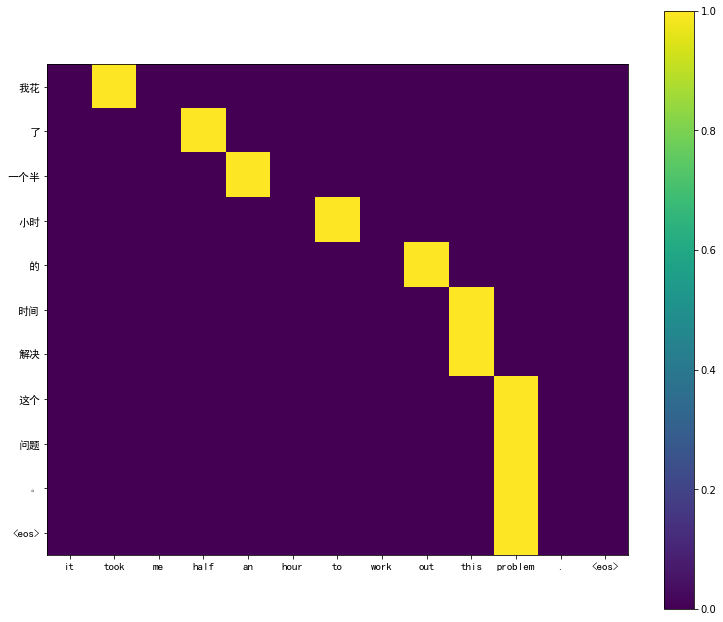

['in', 'this', 'case', ',', 'the', 'adjective', 'goes', 'before', 'the', 'noun', '.', '<eos>']
【原文】
inthiscase,theadjectivegoesbeforethenoun.<eos>
【原文】
在 这种 情况 下 ， 形容词 放在 名词 前面 。
【机器翻译】
['在', '这种', '情况', '下', '，', '形容词', '形容词', '形容词', '名词', '前面', '。']

[[1.0, 3.9606557616922444e-11, 9.059380059843796e-29, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 7.461292549585448e-35, 1.0, 3.775900494420015e-17, 2.9076943134739954e-42, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.5880976004731262e-13, 1.0, 9.134597522830745e-10, 2.2179605322584916e-24, 2.3723983001019153e-42, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 7.053630993925909e-34, 5.6201437704658665e-21, 3.0119029492681193e-10, 1.0, 5.88702407323943e-23, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 2.2670854413659326e-32, 0.9999078512191772, 9.216766193276271e-05, 1.901196766855426e-27, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.6494134058575582e-07, 0.9999998807907104, 5.200921882869772e-19, 7.538985738067516e-43, 0.0, 

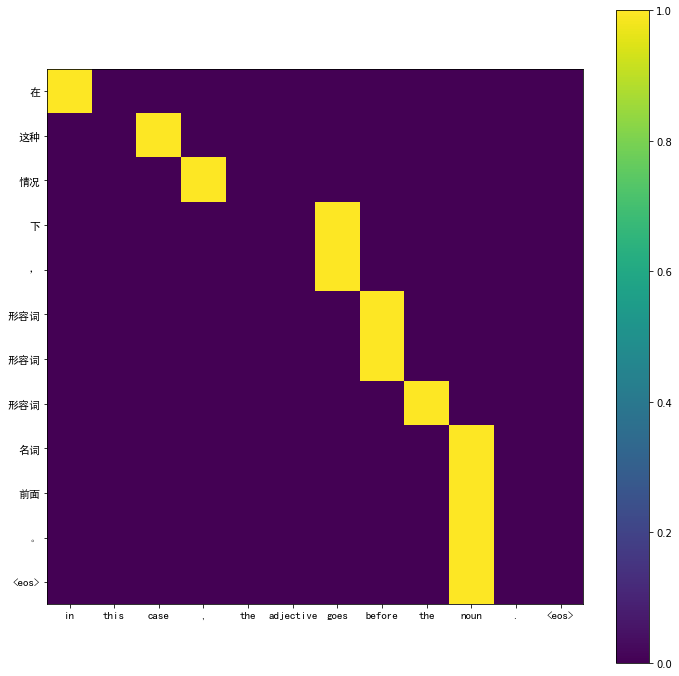

['they', 'did', "n't", 'act', 'quickly', '.', '<eos>']
【原文】
theydidn'tactquickly.<eos>
【原文】
他们 没有 立刻 行动 。
【机器翻译】
['他们', '没有', '读书', '退休', '。']

[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 4.373079201246858e-38, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]]


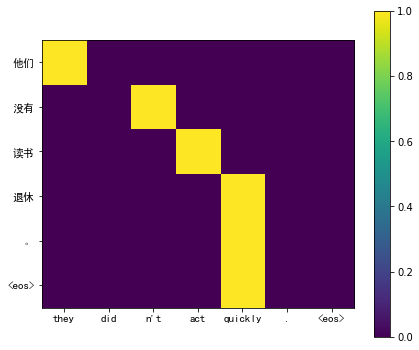

['she', 'tried', 'to', 'commit', 'suicide', '.', '<eos>']
【原文】
shetriedtocommitsuicide.<eos>
【原文】
她 企图 自杀 。
【机器翻译】
['她', '试图', '赶上', '为的是', '。']

[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 2.492475565509909e-40, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 8.445475209669363e-26, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.9999998807907104, 9.909999931778657e-08, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]]


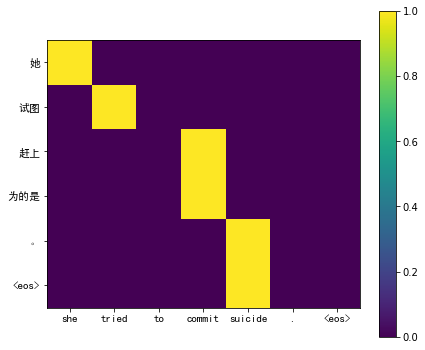

['this', 'sofa', 'takes', 'up', 'too', 'much', 'space', '.', '<eos>']
【原文】
thissofatakesuptoomuchspace.<eos>
【原文】
这张 沙发 占 了 太 多 空间 。
【机器翻译】
['这张', '沙发', '占', '了', '太', '多', '空间', '。']

[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [2.7678862220293458e-33, 1.0, 1.3539289681328543e-19, 1.5414283107572988e-44, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 4.5233914428405095e-41, 2.4336113679801485e-10, 1.0, 4.006526826885043e-14, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 4.1842493211142497e-16, 1.0, 9.925469335314574e-09, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 6.875201865904565e-38, 1.1127612720152058e-10, 1.0, 1.8497139729087585e-43, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 4.49273757213286e-34, 1.0, 2.2420775429197073e-44, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.3808060908878642e-42, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 6.757061194974268e-42, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.802596928649634e-44, 0.0]]


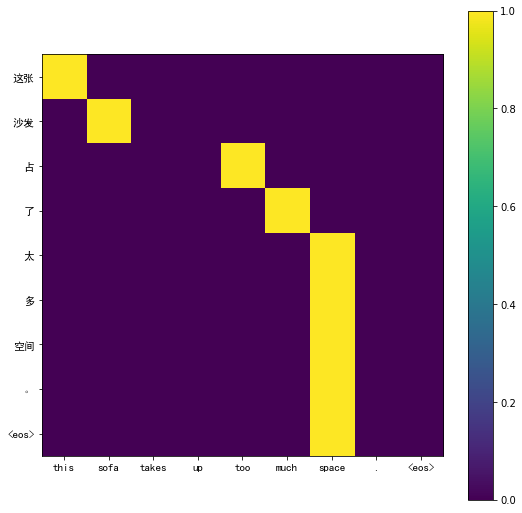

['have', 'you', 'ever', 'eaten', 'japanese', 'food', '?', '<eos>']
【原文】
haveyouevereatenjapanesefood?<eos>
【原文】
你 吃 过 日本料理 吗 ？
【机器翻译】
['你', '吃', '过', '日本料理', '吗', '？']

[[4.318756046143776e-14, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.4179917801296135e-18, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.9641597986193478e-14, 1.0, 7.516845222331184e-41, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.7910086569372652e-07, 0.9999997615814209, 4.8398618752638947e-20, 1.1350517561031018e-43], [0.0, 0.0, 0.0, 0.0, 0.0, 1.1225137267997006e-14, 1.0, 1.6777924908834575e-30], [0.0, 0.0, 0.0, 0.0, 0.0, 3.089103228915375e-36, 1.0, 3.007220403882319e-24], [0.0, 0.0, 0.0, 0.0, 0.0, 6.4107531334612e-34, 1.0, 4.869068911834803e-19]]


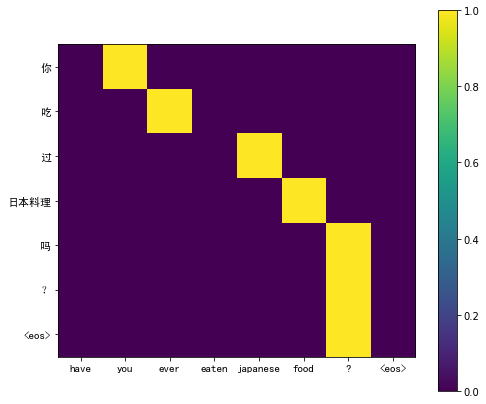

['i', 'do', "n't", 'plan', 'to', 'stay', 'for', 'very', 'long', '.', '<eos>']
【原文】
idon'tplantostayforverylong.<eos>
【原文】
我 没有 打算 停留 太久 。
【机器翻译】
['我', '没有', '打算', '停留', '太久', '。']

[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.9995619654655457, 0.00043802865548059344, 2.8593209523868924e-36, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 2.8213733571647026e-07, 0.9999997615814209, 1.87964172428192e-21, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3679731116554547e-37, 0.13388164341449738, 0.866118311882019, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0373590321615552e-23, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.696630995288702e-24, 1.0, 0.0, 0.0]]


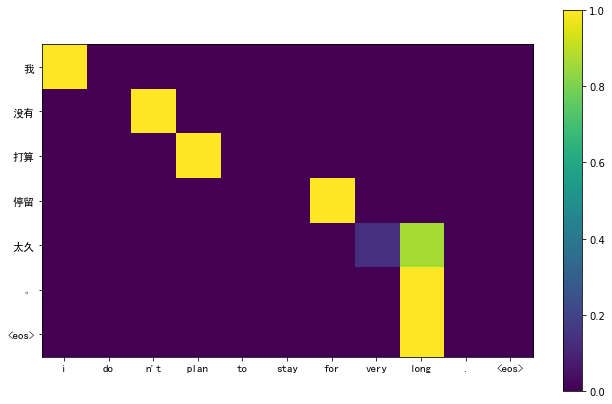

['tom', 'was', 'afraid', 'to', 'ask', 'for', 'help', '.', '<eos>']
【原文】
tomwasafraidtoaskforhelp.<eos>
【原文】
汤姆 不敢 求助 。
【机器翻译】
['汤姆', '不敢', '求助', '。']

[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.4061356272415116e-26, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 2.324717332014432e-28, 1.0, 2.8160623979569013e-37, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.877739942195255e-43, 0.0]]


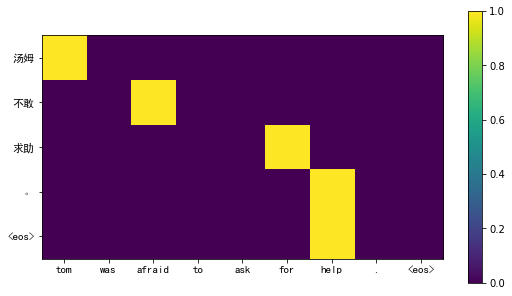

['i', 'was', 'just', 'trying', 'to', 'protect', 'you', '.', '<eos>']
【原文】
iwasjusttryingtoprotectyou.<eos>
【原文】
我 只是 试著 保护 你 。
【机器翻译】
['我', '只是', '试著', '保护', '你', '。']

[[1.0, 2.852903543518895e-41, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 9.599496389033502e-16, 1.0, 3.207572184839506e-42, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.5165148303797338e-10, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]]


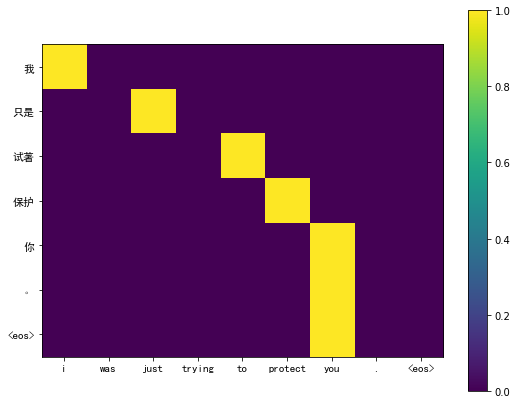

['i', 'truly', 'do', 'not', 'understand', 'the', 'question', '.', '<eos>']
【原文】
itrulydonotunderstandthequestion.<eos>
【原文】
我 真的 不 懂 这个 问题 。
【机器翻译】
['我', '真的', '不', '懂', '这个', '问题', '。']

[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 1.401298464324817e-45, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.033527002443827e-24, 1.0, 1.6133674765205666e-25, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 7.015336662280491e-12, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 3.4191682529525537e-43, 0.023201774805784225, 0.9767981767654419, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 4.249296061920111e-39, 1.0, 1.401298464324817e-45, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.56584313390123e-39, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 4.047650614202234e-41, 1.0, 1.922161327722106e-37, 0.0]]


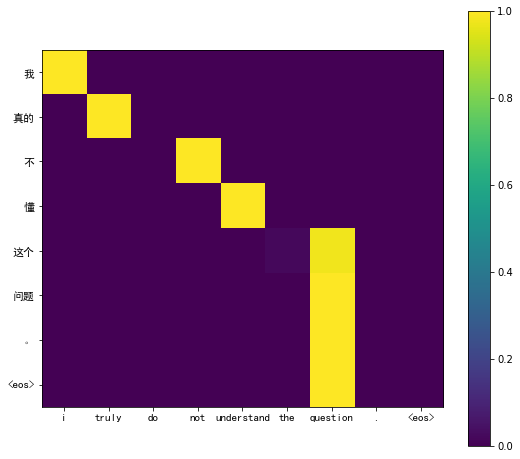

In [106]:
random.seed(2020)
for i in random.sample(range(len(en_num_data)), 10):  # 随机看10个
    en_tokens = list(filter(lambda x: x!=1, en_num_data[i]))  # 过滤零
    ch_tokens = list(filter(lambda x: x!=3 and x!=1, ch_num_data[i]))  # 和机器翻译作对照
    sentence = [en_TEXT.vocab.itos[t] for t in en_tokens]
    print(sentence)
    print("【原文】")
    print("".join(sentence))
    translation = [ch_TEXT.vocab.itos[t] for t in ch_tokens]
    print("【原文】")
    print(" ".join(translation))
    test_sample = {}
    test_sample["src"] = torch.tensor(en_tokens, dtype=torch.long, device=device).reshape(-1, 1)
    test_sample["src_len"] = [len(en_tokens)]
    print("【机器翻译】")
    # print(translate(model, test_sample, ch_TEXT.vocab.itos), end="\n\n")
    output_tokens, attn_info = translate(model, test_sample, ch_TEXT.vocab.itos)
    print(output_tokens, end="\n\n")
    print(attn_info)
    att_show(sentence, output_tokens+['<eos>'], attn_info)

In [ ]:
def translate_sentence(sentence):
  en_tokens = [en_TEXT.vocab.stoi[t] for t in sentence]
  test_sample = {}
  test_sample["src"] = torch.tensor(en_tokens, dtype=torch.long, device=device).reshape(-1, 1)
  test_sample["src_len"] = [len(en_tokens)]
  print("【机器翻译】")
  print(translate(model, test_sample, ch_TEXT.vocab.itos), end="\n\n")

In [ ]:
test = ['say', 'hi', 'to', 'tom', '!'] + ['<eos>']
translate_sentence(test)

In [ ]:
en_TEXT.vocab.itos